In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import copy
import os
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
from copy import deepcopy

In [3]:
def get_max_weight(network):
    params = list(network.parameters())
    max_val = -np.inf
    for p in params:
        v = torch.max(torch.abs(p))
        if v > max_val:
            max_val = v
    return max_val


def get_max_grad(network):
    max_val = -np.inf
    for param in network.parameters():
        if param.grad is not None:
            v = torch.max(torch.abs(param.grad))
            if v > max_val:
                max_val = v
    return max_val


# Architecture for ACModel, Rollouts, and PPO

In [51]:
# these following functions were coded with reference to
# https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail

def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def init_gru_params(gru):
    for name, param in gru.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0)
        elif 'weight' in name:
            nn.init.orthogonal_(param)

# this is from https://github.com/p-morais/deep-rl/blob/master/rl/distributions/gaussian.py
class DiagonalGaussian(nn.Module):
    def __init__(self, num_outputs, init_std=1, learn_std=True):
        super(DiagonalGaussian, self).__init__()

        self.logstd = nn.Parameter(
            torch.ones(1, num_outputs) * np.log(init_std),
            requires_grad=learn_std
        )

        self.learn_std = learn_std

    def forward(self, x):
        mean = x
        
#         print(self.logstd.sum())
        std = self.logstd.exp()
        
        return mean, std

    def sample(self, x, deterministic):
        if deterministic is False:
            action = self.evaluate(x).sample()
        else:
            action, _ = self(x)

        return action

    def evaluate(self, x):
        mean, std = self(x)
        output = torch.distributions.Normal(mean, std)
        return output

    
class ACModel(nn.Module):
    def __init__(self, num_tickers, time_horizon, num_ta_indicators, recurrent, hidden_size=64, learn_std=True):
        super().__init__()
        
        # num tickers, time horizon, and num ta used to compute the number of inputs
        # for recurrent network, the input size to GRU is just the num tickers (prices at each timestep)
        # and input size to the actor/critic is the current cash, holdings, and technical analysis for each ticker
        # for feedforward, the input size is num tickers * time horizon
        # and input size to the actor/critic is the current cash, holdings, and technical analysis for each ticker
        self.num_tickers = num_tickers
        self.time_horizon = time_horizon
        self.num_ta_indicators = num_ta_indicators
        
        # TODO changed for cartpole
        # action_dim = num_tickers + 1 # buy/sell for each ticker + 1 for cash
        action_dim = 1
        self.action_dim = action_dim
        
        self.hidden_size = hidden_size
        
        self.recurrent = recurrent
        if self.recurrent:
            num_inputs = num_tickers
            
            self.gru_actor = nn.GRU(num_inputs, hidden_size, batch_first=True)
            self.gru_critic = nn.GRU(num_inputs, hidden_size, batch_first=True)
            
            init_gru_params(self.gru_actor)
            init_gru_params(self.gru_critic)
        else:
            num_inputs = num_tickers * time_horizon
            
            self.fwd_actor = nn.Sequential(nn.Linear(num_inputs, hidden_size), nn.Tanh())
            self.fwd_critic = nn.Sequential(nn.Linear(num_inputs, hidden_size), nn.Tanh())
        
        # output of gru/fwd, cash, holdings, and then all the ta indicators
        # TODO changed for cartpole
        # num_inputs = hidden_size + 1 + num_tickers + num_tickers * num_ta_indicators
        num_inputs = hidden_size
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, action_dim)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        self.dist = DiagonalGaussian(action_dim, learn_std=learn_std)

        self.apply(init_params)
    
    def init_hidden(self, batch_size, hidden_size):
        # h0 should be of shape (num_layers * num_directions, batch size, hidden_size)
        # num_layers is 1, and RNN is not bidirectional, so num_dir = 1
        # (1, batch_size, hidden size)
        h = torch.zeros(1, batch_size, hidden_size)
        return nn.Parameter(h, requires_grad=True)

    def forward(self, obs, rnn_h_a=None, rnn_h_c=None):
        # suppose obs is just a vector of previous prices
        price_obs_in = obs[:,:self.num_tickers * self.time_horizon]
        other_obs = obs[:,self.num_tickers * self.time_horizon:]
        
        price_obs = torch.zeros(price_obs_in.shape)
        
        price_obs[:,1::4] = torch.sin(price_obs_in[:,1::4])
        price_obs[:,0::4] = price_obs_in[:,0::4]
#         price_obs[:,2::4] = price_obs_in[:,2::4]
#         price_obs[:,3::4] = torch.cos(price_obs_in[:,3::4]) * price_obs_in[:,1::4]
        
#         print(price_obs, price_obs_in)
        
        if self.recurrent:
            if rnn_h_a is None:
                rnn_h_a = self.init_hidden(obs.size(0), self.hidden_size)
            if rnn_h_c is None:
                rnn_h_c = self.init_hidden(obs.size(0), self.hidden_size)
            
            obs = torch.reshape(price_obs, (-1, self.time_horizon, self.num_tickers))
            obs_actor, rnn_h_a = self.gru_actor(obs, rnn_h_a)

            obs_actor = obs_actor[:,-1,:] # selecting the last element
            
            obs_critic, rnn_h_c = self.gru_critic(obs, rnn_h_c)
            obs_critic = obs_critic[:,-1,:] # selecting the last element
        else:
            obs_actor = self.fwd_actor(price_obs)
            obs_critic = self.fwd_critic(price_obs)
            
#         obs_actor = torch.cat((obs_actor, other_obs), 1)
#         obs_critic = torch.cat((obs_critic, other_obs), 1)
        
        forward_actor = self.actor(obs_actor)
        action_dist = self.dist.evaluate(forward_actor)
        
        forward_critic = self.critic(obs_critic)
        
        return action_dist, forward_critic, rnn_h_a, rnn_h_c

In [52]:
class RolloutBuffer:
    def __init__(self, acmodel, env, discount=0.995, gae_lambda=0.95, device=None):
        # TODO changed for cartpole
        # self.episode_length = env.episode_length
        self.episode_length = 200
        self.device = device
        self.acmodel = acmodel
        self.discount = discount
        self.gae_lambda = gae_lambda
        
        self.actions = None
        self.values = None
        self.rewards = None
        self.log_probs = None
        self.obss = None
        self.gaes = None
        
        self.reset()
        
    def reset(self):
        self.actions = torch.zeros(self.episode_length, device=self.device)
        self.values = torch.zeros(self.episode_length, device=self.device)
        self.rewards = torch.zeros(self.episode_length, device=self.device)
        self.log_probs = torch.zeros(self.episode_length, device=self.device)
        self.obss = [None] * self.episode_length
    
    def process_obs(self, obs):
        # TODO: formatting stuff
        if isinstance(obs, list):
            obs = np.stack(obs)

        if len(obs.shape) == 1: # 1 dimensional
            obs = np.expand_dims(obs, axis=0)
            
        return torch.FloatTensor(obs)
    
    def collect_experience(self):
        obs = env.reset()
        total_return = 0
        T = 0
        
        while True:
            with torch.no_grad():
                dist, value, _, _ = self.acmodel(self.process_obs(obs))
                
            action = dist.sample()
            
            self.obss[T] = obs
            
            obs, reward, done, _ = env.step(action)
            
            total_return += reward
            
            self.actions[T] = action
            self.values[T] = value
            self.rewards[T] = float(reward)
            self.log_probs[T] = dist.log_prob(action)
            
            
            T += 1
            if done:
                break
                
        self.actions = self.actions[:T]
        self.values = self.values[:T]
        self.rewards = self.rewards[:T]
        self.log_probs = self.log_probs[:T]
        self.obss = self.process_obs(self.obss[:T])
        self.gaes = self.compute_advantage_gae(T)
        

        
        return total_return, T
            
    def compute_advantage_gae(self, T):
        def _delta(t, rewards, discount, values):
            return rewards[t] + ((discount * values[t+1] - values[t]) if t+1 < values.shape[0] else 0)

        advantages = torch.zeros_like(self.values)

        n = self.values.shape[0]
        for t in range(n):
            advantages[t] = sum([(self.gae_lambda*self.discount)**i * _delta(t+i, self.rewards, self.discount, self.values) for i in range(n-t)])

        return advantages[:T]
        

In [53]:
class PPO:
    def __init__(self,
                 acmodel,
                 clip_ratio=0.2,
                 entropy_coef=0.01,
                 lr=1e-3,
                 target_kl=0.01,
                 train_iters=10):
        
        self.acmodel = acmodel
        self.clip_ratio = clip_ratio
        self.entropy_coef = entropy_coef
        self.target_kl=target_kl
        self.train_iters = train_iters
        
        self.optimizer = torch.optim.Adam(acmodel.parameters(), lr=lr)
        
    def update(self, rollouts):
        # rollouts should be RolloutBuffer object
        dist, _, _, _ = self.acmodel(rollouts.obss) # TODO may need to process these observations
        old_logp = dist.log_prob(rollouts.actions.view(-1,self.acmodel.action_dim)).detach()
        

        policy_loss, _ = self._compute_policy_loss_ppo(rollouts.obss, old_logp, rollouts.actions, rollouts.gaes)
        value_loss = self._compute_value_loss(rollouts.obss, rollouts.rewards)
        
        for i in range(self.train_iters):
            self.optimizer.zero_grad()
            pi_loss, approx_kl = self._compute_policy_loss_ppo(rollouts.obss, old_logp, rollouts.actions, rollouts.gaes)

            v_loss = self._compute_value_loss(rollouts.obss, rollouts.rewards)
            #print ('vloss:', v_loss, 'pi_loss:', pi_loss)
            loss = v_loss + pi_loss
            
            if approx_kl > 1.5 * self.target_kl:
                break
            
            loss.backward(retain_graph=True) # lol todo are we supposed to retain graph?

            self.optimizer.step()
            
        return policy_loss.item(), value_loss.item()
        
    def _compute_policy_loss_ppo(self, obs, old_logp, actions, advantages):
        policy_loss, approx_kl = 0, 0
        

        dist, _, _, _ = self.acmodel(obs)
        
        new_logp = dist.log_prob(actions.view(-1,self.acmodel.action_dim))
        
        entropy = torch.mean(dist.entropy())
        entropy = entropy * self.entropy_coef

        r = torch.exp(new_logp - old_logp.detach())

        clamp_adv = torch.clamp(r, 1-self.clip_ratio, 1+self.clip_ratio)*advantages.view(-1,1)
        
        min_advs = torch.minimum(r*advantages.view(-1,1), clamp_adv)

        policy_loss = -torch.mean(min_advs) - entropy
        approx_kl = (old_logp - new_logp).mean()
        
        return policy_loss, approx_kl
    
    def _compute_value_loss(self, obs, returns):
        _, values, _, _ = self.acmodel(obs)

        value_loss = torch.mean((returns.view(-1,1) - values.view(-1,1))**2)
        
        return value_loss



# Cartpole Gym Attempt

In [54]:
import gym
from gym.envs.registration import registry, register

In [56]:
class CartpoleDynamics:
    def __init__(self,
                 timestep=0.02,
                 m_p=0.5,
                 m_c=0.5,
                 l=0.6,
                 g=-9.81,
                 u_range=15):
        
        self.m_p  = m_p
        self.m_c  = m_c
        self.l    = l
        self.g    = -g
        self.dt   = timestep
        
        self.u_range = u_range

        self.u_lb = torch.tensor([-1]).float()
        self.u_ub = torch.tensor([1]).float()
        self.q_shape = 4
        self.u_shape = 1
    
    def _qdotdot(self, q, u):
        x, theta, xdot, thetadot = q.T

        if len(u.shape) == 2:
            u = torch.flatten(u)
        
        x_dotdot = (
            u + self.m_p * torch.sin(theta) * (
                self.l * torch.pow(thetadot,2) + self.g * torch.cos(theta)
            )
        ) / (self.m_c + self.m_p * torch.sin(theta)**2)
        
        theta_dotdot = (
            -u*torch.cos(theta) -
            self.m_p * self.l * torch.pow(thetadot,2) * torch.cos(theta) * torch.sin(theta) - 
            (self.m_c + self.m_p) * self.g * torch.sin(theta)
        ) / (self.l * (self.m_c + self.m_p * torch.sin(theta)**2))
                
        return torch.stack((x_dotdot, theta_dotdot), dim=-1)
    
    def _euler_int(self, q, qdotdot):
        qdot_new = q[...,2:] + qdotdot * self.dt
        q_new = q[...,:2] + self.dt * qdot_new

        return torch.cat((q_new, qdot_new), dim=-1)
    
    def step(self, q, u):
        # Check for numpy array
        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        scaled_u = u * float(self.u_range)    
            
        # Check for shape issues
        if len(q.shape) == 2:
            q_dotdot = self._qdotdot(q, scaled_u)
        elif len(q.shape) == 1:
            q_dotdot = self._qdotdot(q.reshape(1,-1), scaled_u)
        else:
            raise RuntimeError('Invalid q shape')
            
        new_q = self._euler_int(q, q_dotdot)

        if len(q.shape) == 1:
            new_q = new_q[0]
            
        return new_q
    
    # given q [n, q_shape] and u [n, t] run the trajectories
    def run_batch_of_trajectories(self, q, u):
        qs = [q]
        
        for t in range(u.shape[1]):
            qs.append(self.step(qs[-1], u[:,t]))
                
        return torch.stack(qs, dim=1)
    
    def reward(self, q, u):
        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        angle_term = 0.5*(1-torch.cos(q[...,1]))
        pos_term = -0.5*torch.pow(q[...,0],2)
        ctrl_cost = -0.001*(u**2).sum(dim=-1)
                        
        return angle_term + pos_term + ctrl_cost
    
class CartpoleGym(gym.Env):
    def __init__(self, time_horizon=3, timestep_limit=200):
        self.dynamics = CartpoleDynamics()
        
        self.timestep_limit = timestep_limit
        self.time_horizon = time_horizon
        self.reset()

    def reset(self):
        self.q_sim = np.zeros(4)
        self.timesteps = 0

        self.traj = [self.get_observation()[:2]]
        
        for t in range(self.time_horizon-1):
            # start with a few random actions to initialize
#             action = np.random.uniform(low=self.dynamics.u_lb.numpy()/10, high = self.dynamics.u_ub.numpy()/10)
            action = np.zeros(1)
            self.step(action)
        
        return np.array(self.traj[-self.time_horizon:]).flatten()

    def get_observation(self):
        return self.q_sim
            
    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)[0]
        
        new_q = self.dynamics.step(
            self.q_sim, action
        )
        
        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action)
        
        reward = self.dynamics.reward(
            new_q, action
        ).numpy()
        
        self.q_sim = new_q.numpy()
        done = self.is_done()
        
        self.timesteps += 1

        self.traj.append(self.q_sim[:2])
        
        return np.array(self.traj[-self.time_horizon:]).flatten(), reward, done, {}
    
    def is_done(self):
        # Kill trial when too much time has passed
        if self.timesteps >= self.timestep_limit:
            return True
                
        return False
        
    @property
    def action_space(self):
        return gym.spaces.Box(low=self.dynamics.u_lb.numpy(), high=self.dynamics.u_ub.numpy())

    @property
    def observation_space(self):
        return gym.spaces.Box(
            low= np.array([-np.inf, -np.inf, -np.inf, -np.inf]),
            high=np.array([np.inf,   np.inf,  np.inf,  np.inf])
        )
    
env_name = 'CartpoleWithMemory-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:CartpoleGym',
)
env = gym.make('CartpoleWithMemory-v0')

In [57]:
env.reset()

array([0., 0., 0., 0., 0., 0.])

In [59]:
# recurrent model
acmodel = ACModel(num_tickers=2, time_horizon=3, num_ta_indicators=0, recurrent=True, hidden_size=32)
rollouts = RolloutBuffer(acmodel, env)
rollouts.collect_experience()
ppo = PPO(acmodel)
ppo.update(rollouts)

(-0.4050545394420624, 0.25721898674964905)

In [61]:
# feedforward model
acmodel = ACModel(num_tickers=2, time_horizon=3, num_ta_indicators=0, recurrent=False, hidden_size=32)
rollouts = RolloutBuffer(acmodel, env)
rollouts.collect_experience()
ppo = PPO(acmodel)
ppo.update(rollouts)

(4253.1728515625, 148840.109375)

Ok so looks like the Cartpole gym syntactically works.. Let's try to train

# Run experiment on Cartpole

In [38]:
# Adapted from 6.884 HW4

def run_experiment(acmodel, ppo_kwargs, rollout_kwargs, max_episodes=200000, score_threshold=0.8):
    # acmodel_args should be dictionary corresponding to inputs of acmodel
    # ie {num_tickers: 4, time_horizon: 5, etc..}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make('CartpoleWithMemory-v0')
    
    
    acmodel.to(device)

    is_solved = False
    
    SMOOTH_REWARD_WINDOW = 30

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW
    
    num_frames = 0
    rollouts = RolloutBuffer(acmodel, env, **rollout_kwargs)
    ppo = PPO(acmodel, **ppo_kwargs)

    pbar = tqdm(range(max_episodes))
    for update in pbar:
        rollouts.reset() # resetting the buffer
        total_return, T = rollouts.collect_experience()
        policy_loss, value_loss = ppo.update(rollouts)
        
        num_frames += T
        rewards.append(total_return)
        
        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':total_return, 'policy_loss': policy_loss}

        pd_logs.append(data)

        pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= score_threshold:
            is_solved = True
            break

    if is_solved:
        print('Solved!')
    else:
        print('Unsolved. Check your implementation.')
    
    return pd.DataFrame(pd_logs).set_index('episode')

100%|██████████| 2000/2000 [35:17<00:00,  1.06s/it, episode=1999, num_frames=398000, smooth_reward=47.6, reward=48.5, policy_loss=-4.44]          

Unsolved. Check your implementation.
Num eps:  2000


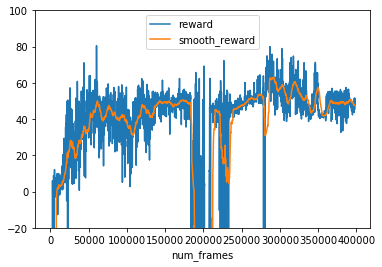

 70%|██████▉   | 1398/2000 [23:23<10:04,  1.00s/it, episode=1398, num_frames=278401, smooth_reward=70.3, reward=68.7, policy_loss=-6.34]   

Solved!
Num eps:  1399


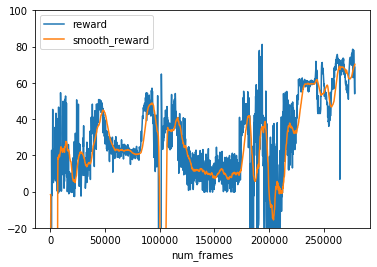

100%|██████████| 2000/2000 [35:28<00:00,  1.06s/it, episode=1999, num_frames=398000, smooth_reward=1.15, reward=0.988, policy_loss=-.0914]     

Unsolved. Check your implementation.
Num eps:  2000


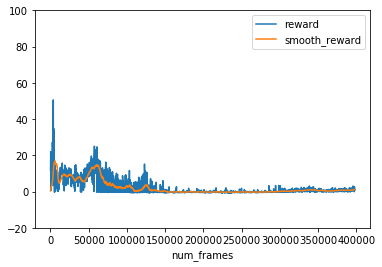

 76%|███████▌  | 1522/2000 [26:33<08:20,  1.05s/it, episode=1522, num_frames=303077, smooth_reward=70.7, reward=87.9, policy_loss=-7.94]       

Solved!
Num eps:  1523


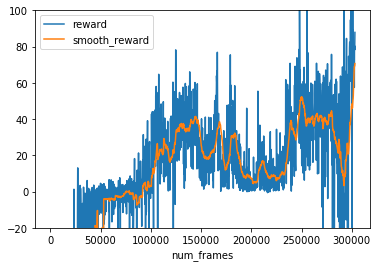

100%|██████████| 2000/2000 [33:29<00:00,  1.00s/it, episode=1999, num_frames=398000, smooth_reward=19.7, reward=20, policy_loss=-1.86]    


Unsolved. Check your implementation.
Num eps:  2000


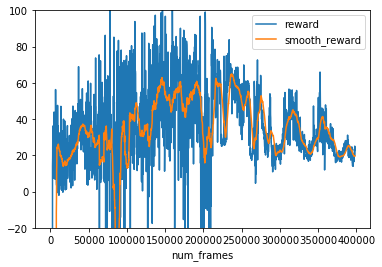

100%|██████████| 2000/2000 [33:53<00:00,  1.02s/it, episode=1999, num_frames=398000, smooth_reward=-369, reward=-325, policy_loss=29.2]         


Unsolved. Check your implementation.
Num eps:  2000


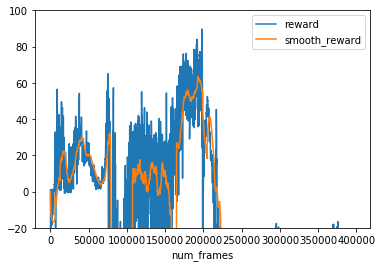

100%|██████████| 2000/2000 [34:53<00:00,  1.05s/it, episode=1999, num_frames=398000, smooth_reward=44.4, reward=58.3, policy_loss=-5.35]         

Unsolved. Check your implementation.
Num eps:  2000


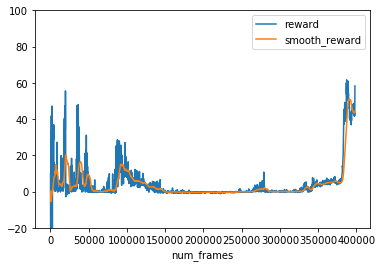

 52%|█████▏    | 1030/2000 [19:16<18:09,  1.12s/it, episode=1030, num_frames=205169, smooth_reward=70.3, reward=81.6, policy_loss=-7.39]    

Solved!
Num eps:  1031


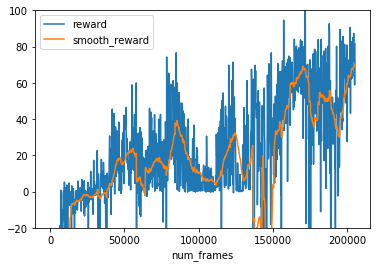

 47%|████▋     | 942/2000 [16:15<18:15,  1.04s/it, episode=942, num_frames=187657, smooth_reward=70.3, reward=81.7, policy_loss=-7.43]     

Solved!
Num eps:  943


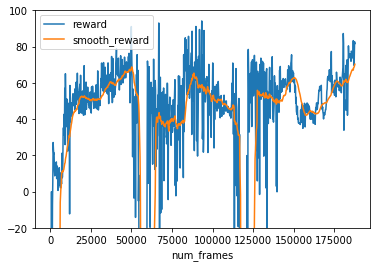

 26%|██▌       | 524/2000 [08:54<25:04,  1.02s/it, episode=524, num_frames=104475, smooth_reward=71.9, reward=92.6, policy_loss=-8.47]      

Solved!
Num eps:  525


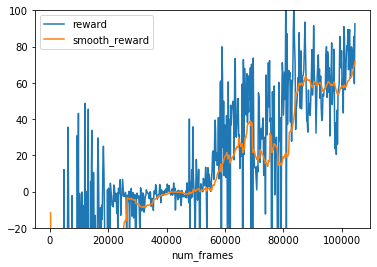

In [21]:
# feedforward
fwd = []
for i in range(10):
    acmodel_kwargs = {'num_tickers': 4, 'time_horizon': 3, 'num_ta_indicators': 0, 'recurrent': False, 'hidden_size': 32}
    acmodel = ACModel(**acmodel_kwargs)
    ppo_kwargs = {'lr': 1e-3, 'entropy_coef': 0.01, 'train_iters': 10}
    fwd_df = run_experiment(acmodel, ppo_kwargs, max_episodes=2000, score_threshold=70)
    print("Num eps: ", len(fwd_df))
    ax=fwd_df.plot(x='num_frames', y=['reward', 'smooth_reward'])
    ax.set_ylim((-20, 100))
    plt.show()
    fwd.append(fwd_df)

100%|██████████| 2000/2000 [34:24<00:00,  1.03s/it, episode=1999, num_frames=398000, smooth_reward=0.235, reward=0.691, policy_loss=-.0693]    

Unsolved. Check your implementation.
Num eps:  2000


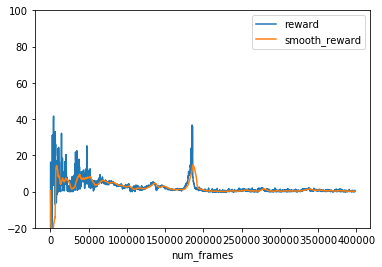

100%|██████████| 2000/2000 [33:48<00:00,  1.01s/it, episode=1999, num_frames=398000, smooth_reward=4.26, reward=3.3, policy_loss=-.295]     


Unsolved. Check your implementation.
Num eps:  2000


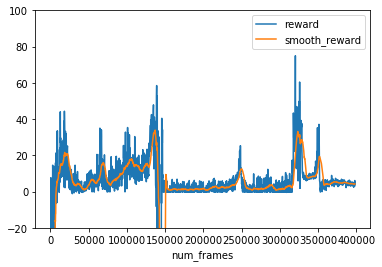

100%|██████████| 2000/2000 [35:50<00:00,  1.08s/it, episode=1999, num_frames=398000, smooth_reward=38.5, reward=45.9, policy_loss=-4.23]         

Unsolved. Check your implementation.
Num eps:  2000


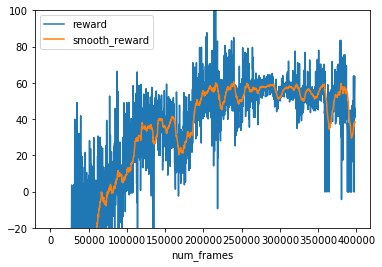

100%|██████████| 2000/2000 [34:12<00:00,  1.03s/it, episode=1999, num_frames=398000, smooth_reward=-14.7, reward=11.6, policy_loss=-1.06]         


Unsolved. Check your implementation.
Num eps:  2000


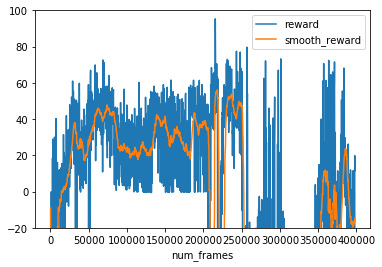

100%|██████████| 2000/2000 [35:45<00:00,  1.07s/it, episode=1999, num_frames=398000, smooth_reward=0.458, reward=0.329, policy_loss=-.0192]    

Unsolved. Check your implementation.
Num eps:  2000


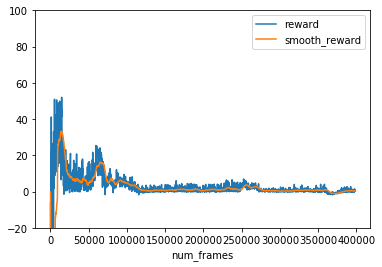

 49%|████▉     | 987/2000 [18:55<19:25,  1.15s/it, episode=987, num_frames=196612, smooth_reward=70.1, reward=68.4, policy_loss=-6.31]    

Solved!
Num eps:  988


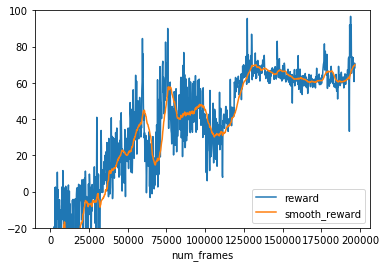

100%|██████████| 2000/2000 [33:02<00:00,  1.01it/s, episode=1999, num_frames=398000, smooth_reward=-5.74, reward=-4.25, policy_loss=0.394]   

Unsolved. Check your implementation.
Num eps:  2000


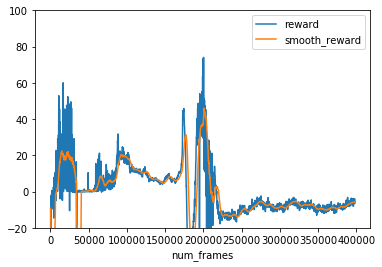

100%|██████████| 2000/2000 [34:14<00:00,  1.03s/it, episode=1999, num_frames=398000, smooth_reward=12.7, reward=4.46, policy_loss=-.41]     

Unsolved. Check your implementation.
Num eps:  2000


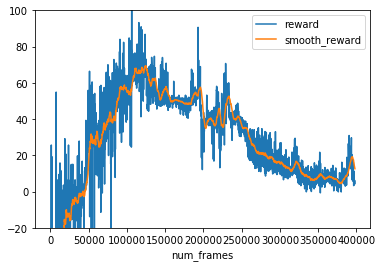

100%|██████████| 2000/2000 [27:43<00:00,  1.20it/s, episode=1999, num_frames=398000, smooth_reward=-82.7, reward=-140, policy_loss=12.6]     


Unsolved. Check your implementation.
Num eps:  2000


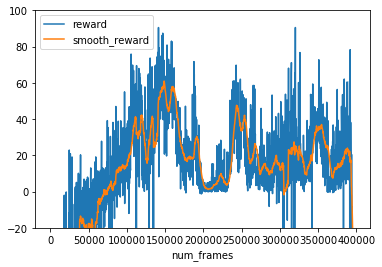

100%|██████████| 2000/2000 [23:43<00:00,  1.41it/s, episode=1999, num_frames=398000, smooth_reward=0.999, reward=2.66, policy_loss=-.231]   

Unsolved. Check your implementation.
Num eps:  2000


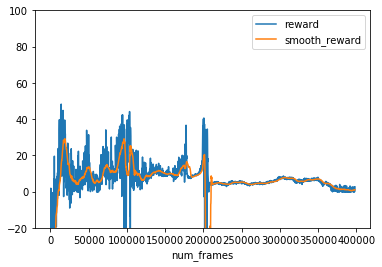

In [24]:
# recurrent
rnn = []
for i in range(10):
    acmodel_kwargs = {'num_tickers': 4, 'time_horizon': 3, 'num_ta_indicators': 0, 'recurrent': True, 'hidden_size': 32}
    acmodel = ACModel(**acmodel_kwargs)
    ppo_kwargs = {'lr': 1e-3, 'train_iters': 10}
    rnn_df = run_experiment(acmodel, ppo_kwargs, max_episodes=2000, score_threshold=70)
    print("Num eps: ", len(rnn_df))
    ax=rnn_df.plot(x='num_frames', y=['reward', 'smooth_reward'])
    ax.set_ylim((-20, 100))
    plt.show()
    rnn.append(rnn_df)

100%|██████████| 2000/2000 [24:22<00:00,  1.37it/s, episode=1999, num_frames=398000, smooth_reward=33.6, reward=-6.71, policy_loss=0.592]   


Unsolved. Check your implementation.
Num eps:  2000


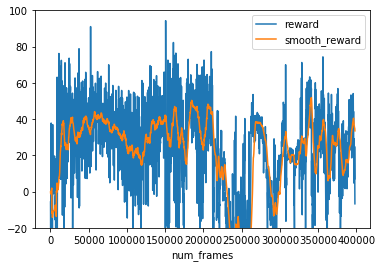

 45%|████▌     | 903/2000 [11:00<13:22,  1.37it/s, episode=903, num_frames=179896, smooth_reward=70.3, reward=81.3, policy_loss=-6.73]  

Solved!
Num eps:  904


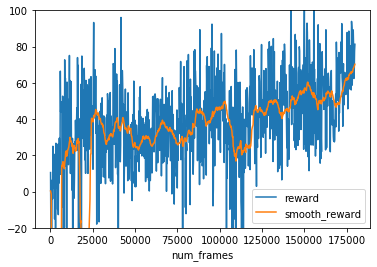

100%|██████████| 2000/2000 [24:49<00:00,  1.34it/s, episode=1999, num_frames=398000, smooth_reward=30.7, reward=18.5, policy_loss=-1.53] 

Unsolved. Check your implementation.
Num eps:  2000


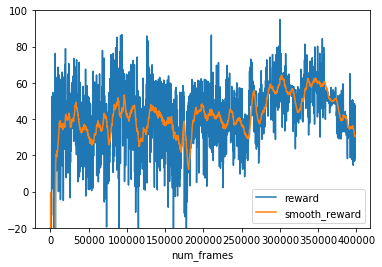

100%|██████████| 2000/2000 [25:04<00:00,  1.33it/s, episode=1999, num_frames=398000, smooth_reward=36.3, reward=41.4, policy_loss=-3.46]

Unsolved. Check your implementation.
Num eps:  2000


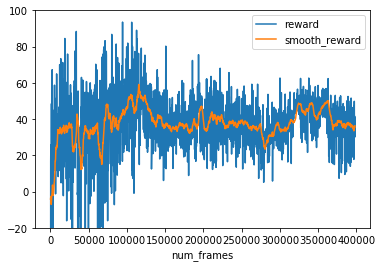

100%|██████████| 2000/2000 [24:23<00:00,  1.37it/s, episode=1999, num_frames=398000, smooth_reward=36.5, reward=28.2, policy_loss=-2.28]  


Unsolved. Check your implementation.
Num eps:  2000


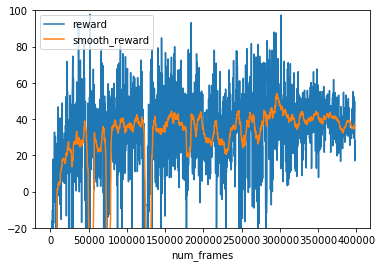

100%|██████████| 2000/2000 [23:30<00:00,  1.42it/s, episode=1999, num_frames=398000, smooth_reward=39.3, reward=42.8, policy_loss=-3.54]   


Unsolved. Check your implementation.
Num eps:  2000


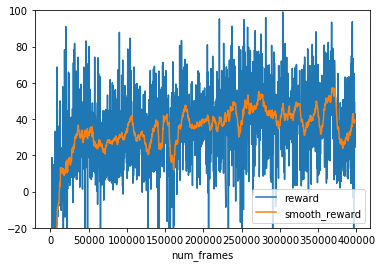

100%|██████████| 2000/2000 [24:10<00:00,  1.38it/s, episode=1999, num_frames=398000, smooth_reward=16.2, reward=34.7, policy_loss=-2.76]    

Unsolved. Check your implementation.
Num eps:  2000


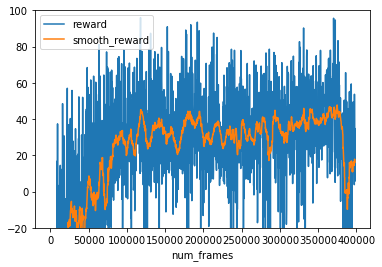

100%|██████████| 2000/2000 [24:38<00:00,  1.35it/s, episode=1999, num_frames=398000, smooth_reward=35.8, reward=43.6, policy_loss=-3.67]   


Unsolved. Check your implementation.
Num eps:  2000


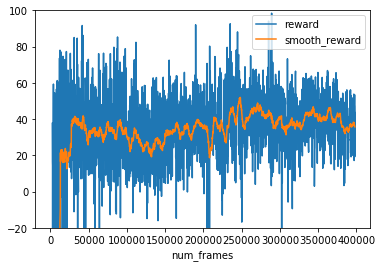

100%|██████████| 2000/2000 [24:15<00:00,  1.37it/s, episode=1999, num_frames=398000, smooth_reward=13.6, reward=21.1, policy_loss=-1.68]    

Unsolved. Check your implementation.
Num eps:  2000


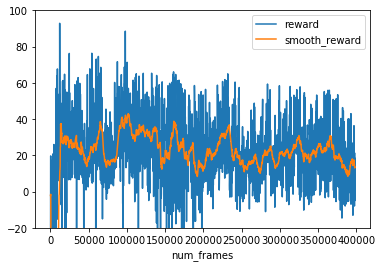

100%|██████████| 2000/2000 [24:31<00:00,  1.36it/s, episode=1999, num_frames=398000, smooth_reward=26.2, reward=14.2, policy_loss=-1.15]   

Unsolved. Check your implementation.
Num eps:  2000


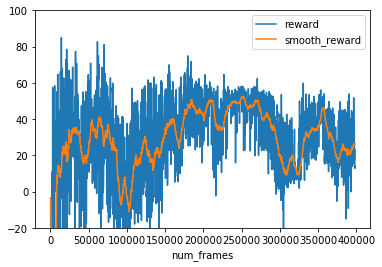

In [63]:
# feedforward
# not all states
fwd = []
for i in range(10):
    acmodel_kwargs = {'num_tickers': 2, 'time_horizon': 3, 'num_ta_indicators': 0, 'recurrent': False, 'hidden_size': 32}
    acmodel = ACModel(**acmodel_kwargs)
    ppo_kwargs = {'lr': 1e-3, 'entropy_coef': 0.01, 'train_iters': 5}
    fwd_df = run_experiment(acmodel, ppo_kwargs, rollout_kwargs, max_episodes=2000, score_threshold=70)
    print("Num eps: ", len(fwd_df))
    ax=fwd_df.plot(x='num_frames', y=['reward', 'smooth_reward'])
    ax.set_ylim((-20, 100))
    plt.show()
    fwd.append(fwd_df)

100%|██████████| 2000/2000 [15:07:06<00:00, 27.21s/it, episode=1999, num_frames=398000, smooth_reward=18.3, reward=20.3, policy_loss=-1.64]        

Unsolved. Check your implementation.
Num eps:  2000


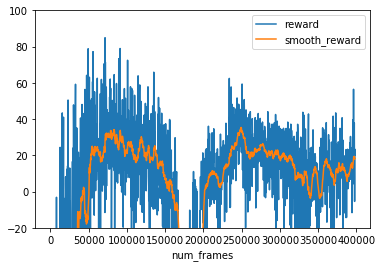

100%|██████████| 2000/2000 [28:47<00:00,  1.16it/s, episode=1999, num_frames=398000, smooth_reward=32.2, reward=27.5, policy_loss=-2.27]  


Unsolved. Check your implementation.
Num eps:  2000


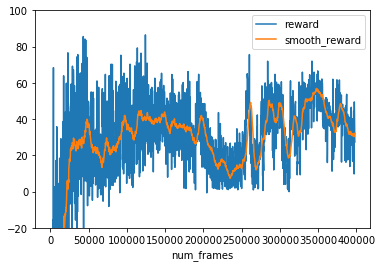

100%|██████████| 2000/2000 [29:22<00:00,  1.14it/s, episode=1999, num_frames=398000, smooth_reward=41.1, reward=47.7, policy_loss=-3.97]    


Unsolved. Check your implementation.
Num eps:  2000


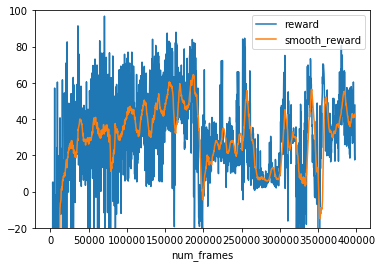

100%|██████████| 2000/2000 [29:36<00:00,  1.13it/s, episode=1999, num_frames=398000, smooth_reward=-2.89e+5, reward=-2.89e+5, policy_loss=2.44e+4]

Unsolved. Check your implementation.
Num eps:  2000


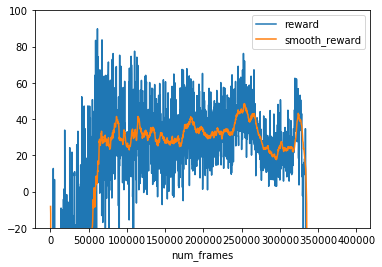

 84%|████████▍ | 1689/2000 [25:53<04:46,  1.09it/s, episode=1689, num_frames=336310, smooth_reward=70.8, reward=91.9, policy_loss=-7.62]       

Solved!
Num eps:  1690


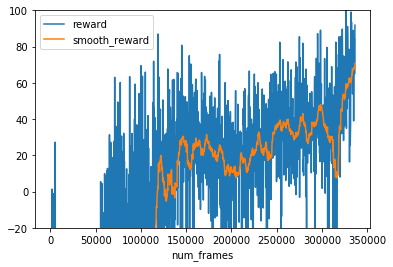

100%|██████████| 2000/2000 [25:00<00:00,  1.33it/s, episode=1999, num_frames=398000, smooth_reward=45.3, reward=36.7, policy_loss=-3.04]     

Unsolved. Check your implementation.
Num eps:  2000


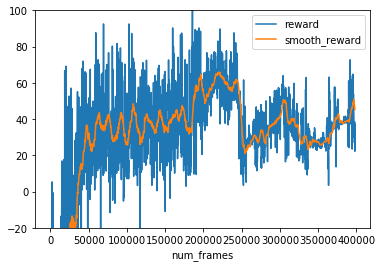

100%|██████████| 2000/2000 [23:50<00:00,  1.40it/s, episode=1999, num_frames=398000, smooth_reward=1.67, reward=0.741, policy_loss=-.0546]   

Unsolved. Check your implementation.
Num eps:  2000


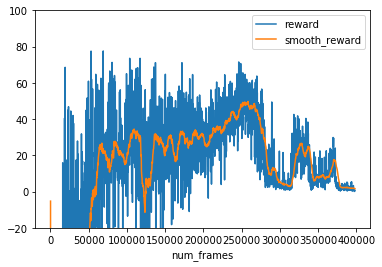

100%|██████████| 2000/2000 [23:43<00:00,  1.41it/s, episode=1999, num_frames=398000, smooth_reward=-67.4, reward=-49.4, policy_loss=4]      

Unsolved. Check your implementation.
Num eps:  2000


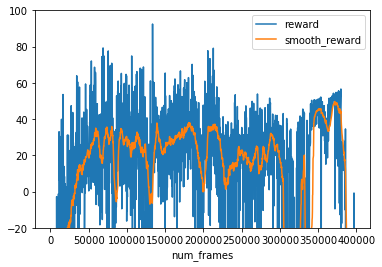

 70%|██████▉   | 1396/2000 [17:29<07:33,  1.33it/s, episode=1396, num_frames=278003, smooth_reward=71.1, reward=74.6, policy_loss=-6.12]    

Solved!
Num eps:  1397


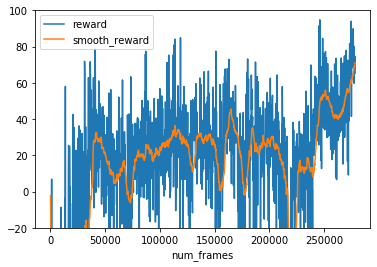

100%|██████████| 2000/2000 [24:07<00:00,  1.38it/s, episode=1999, num_frames=398000, smooth_reward=38, reward=57.6, policy_loss=-4.83]      


Unsolved. Check your implementation.
Num eps:  2000


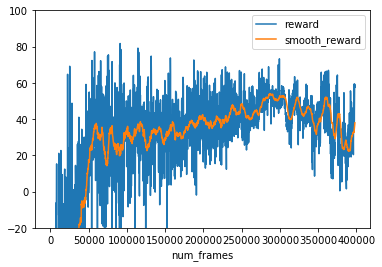

In [65]:
# recurrent

# with rollout kwargs, 0 as initial actions
rnn = []
for i in range(10):
    acmodel_kwargs = {'num_tickers': 2, 'time_horizon': 3, 'num_ta_indicators': 0, 'recurrent': True, 'hidden_size': 32}
    acmodel = ACModel(**acmodel_kwargs)
    ppo_kwargs = {'lr': 1e-3, 'train_iters': 10}
    rollout_kwargs = {'discount': .99, 'gae_lambda': .95}
    rnn_df = run_experiment(acmodel, ppo_kwargs, rollout_kwargs, max_episodes=2000, score_threshold=70)
    print("Num eps: ", len(rnn_df))
    ax=rnn_df.plot(x='num_frames', y=['reward', 'smooth_reward'])
    ax.set_ylim((-20, 100))
    plt.show()
    rnn.append(rnn_df)

In [21]:
fig.savefig('./plots/rnn_60.png')